# Testing the PET-CT pipeline

Three components:
1. Patient dataset - Derived from torch.utils.data.Dataset.
2. Patch queue - Custom queue + patch sampler based on TorchIO Queue source code. The custom PatchQueue class is derived from torch.utils.data.Dataset.
3. Patch loader - Regular instance of the torch.utils.data.DataLoader.

Note: For visualization purpose, the step for rescaling intensities to unit range in the HECKTORPETCTDataset is disabled to allow viewing using HU and SUV windows.

In [1]:
import os, time

import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import SimpleITK as sitk
from torch.utils.data import DataLoader
import torchio
from torchio.transforms import HistogramStandardization

import sys
sys.path.append('../')
from dataset_classes.HECKTORPETCTDataset import HECKTORPETCTDataset
from data_utils.preprocessing import Preprocessor
from data_utils.patch_sampling import PatchSampler, PatchQueue
from data_utils.visualization import NdimageVisualizer, display_image
from data_utils.conversion import *

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



In [2]:
data_dir = "/home/chinmay/Datasets/HECKTOR/hecktor_train/crFH_rs113_hecktor_nii"
patient_id_filepath = "../hecktor_meta/patient_IDs_train.txt"

preprocessor = Preprocessor()

viz = NdimageVisualizer()

## 1 Testing the dataset class

### 1.1 Separate volume representation

In [3]:
sample_idx = 0

PET_CT_dataset = HECKTORPETCTDataset(data_dir, 
                                     patient_id_filepath, 
                                     mode='training', 
                                     preprocessor=preprocessor,
                                     input_representation='separate-volumes', 
                                     augment_data=False)

sample_dict = PET_CT_dataset[sample_idx]
print(sample_dict['PET'].shape)
print(sample_dict['PET'].min())
print(sample_dict['PET'].max())

# For visualization purpose
PET_np = sample_dict['PET'].squeeze().permute(2,1,0)
CT_np = sample_dict['CT'].squeeze().permute(2,1,0)
GTV_labelmap_np = sample_dict['GTV-labelmap'].squeeze().permute(2,1,0)

torch.Size([1, 100, 450, 450])
tensor(0.)
tensor(20.)


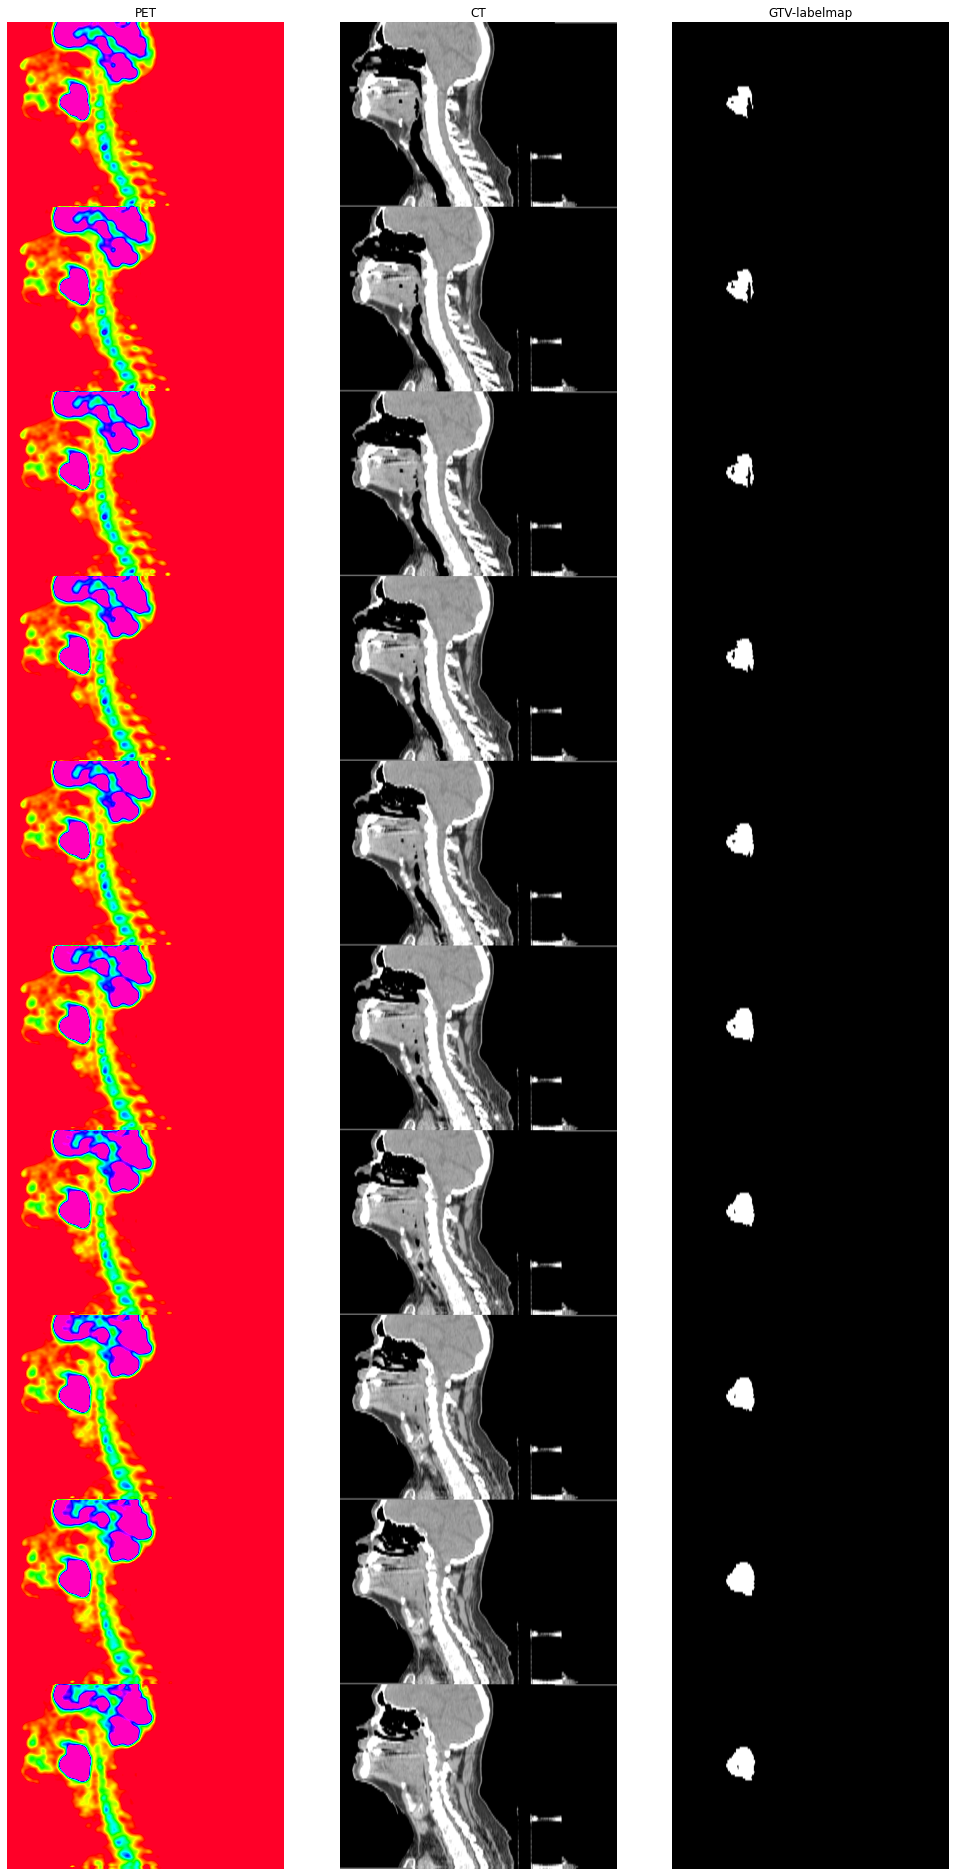

In [4]:
viz.multi_image_strips([PET_np, CT_np, GTV_labelmap_np],
                          modalities=['PET', 'CT', 'GTV-labelmap'],
                          idx_range=[230, 240],
                          view='sagittal',
                          subtitles=[])

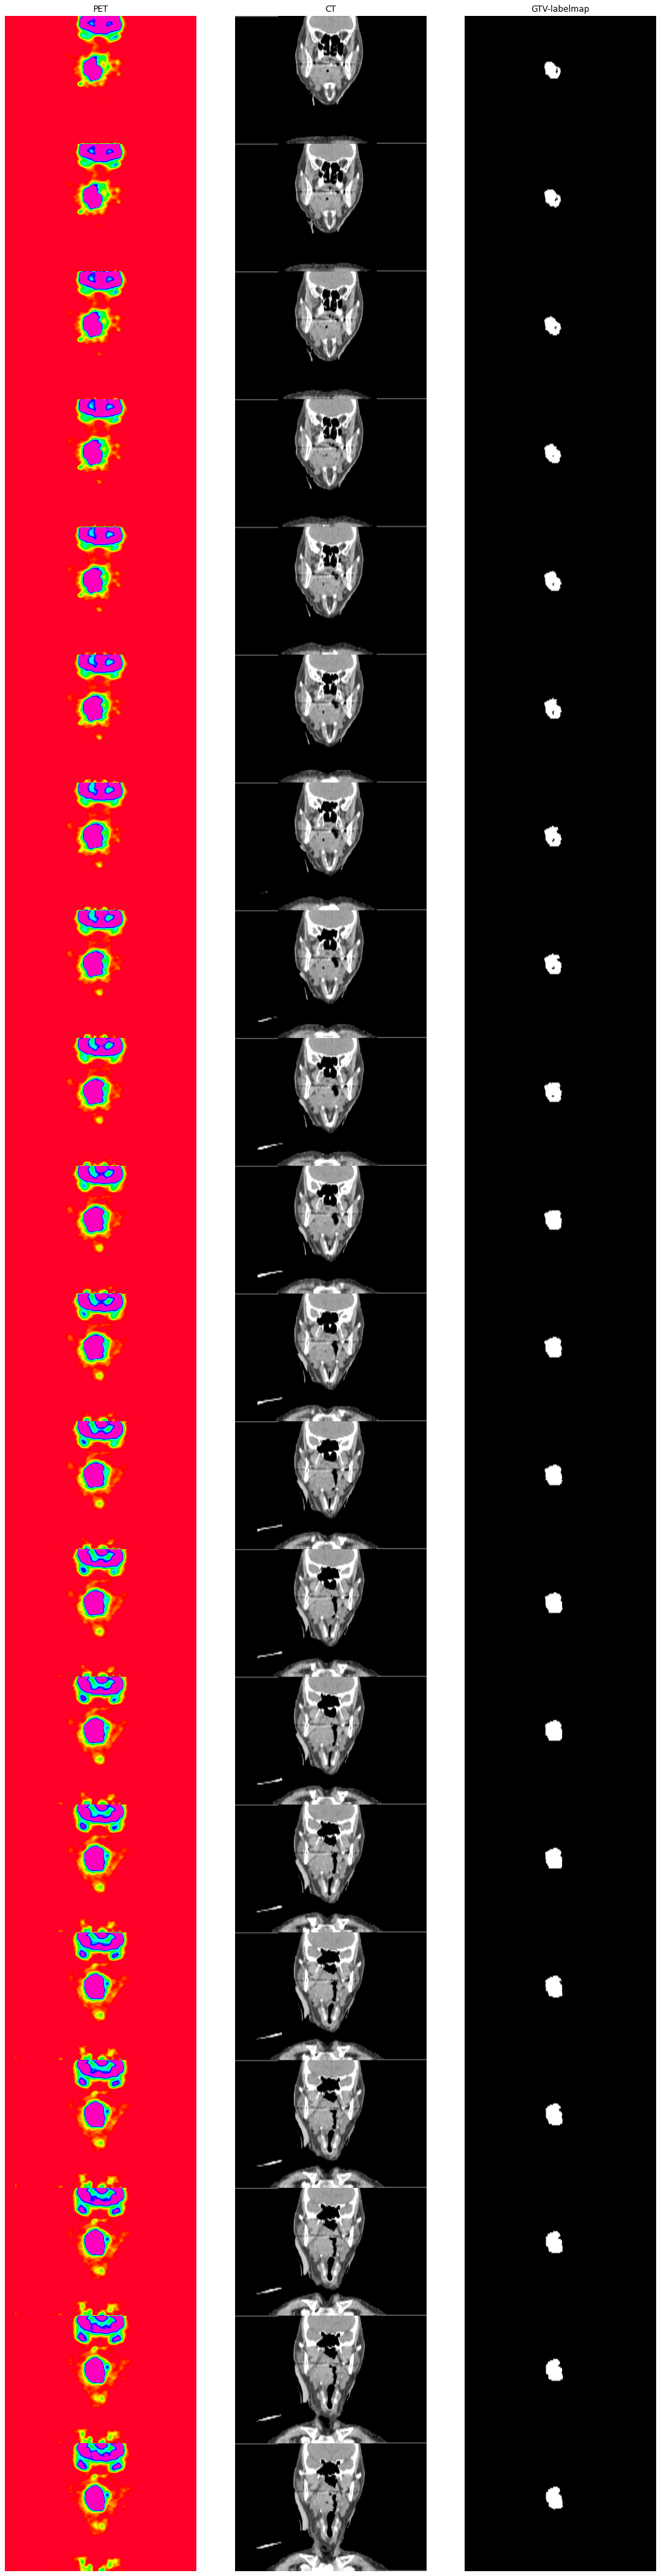

In [5]:
viz.multi_image_strips([PET_np, CT_np, GTV_labelmap_np],
                          modalities=['PET', 'CT', 'GTV-labelmap'],
                          idx_range=[100, 120],
                          view='coronal',
                          subtitles=[])

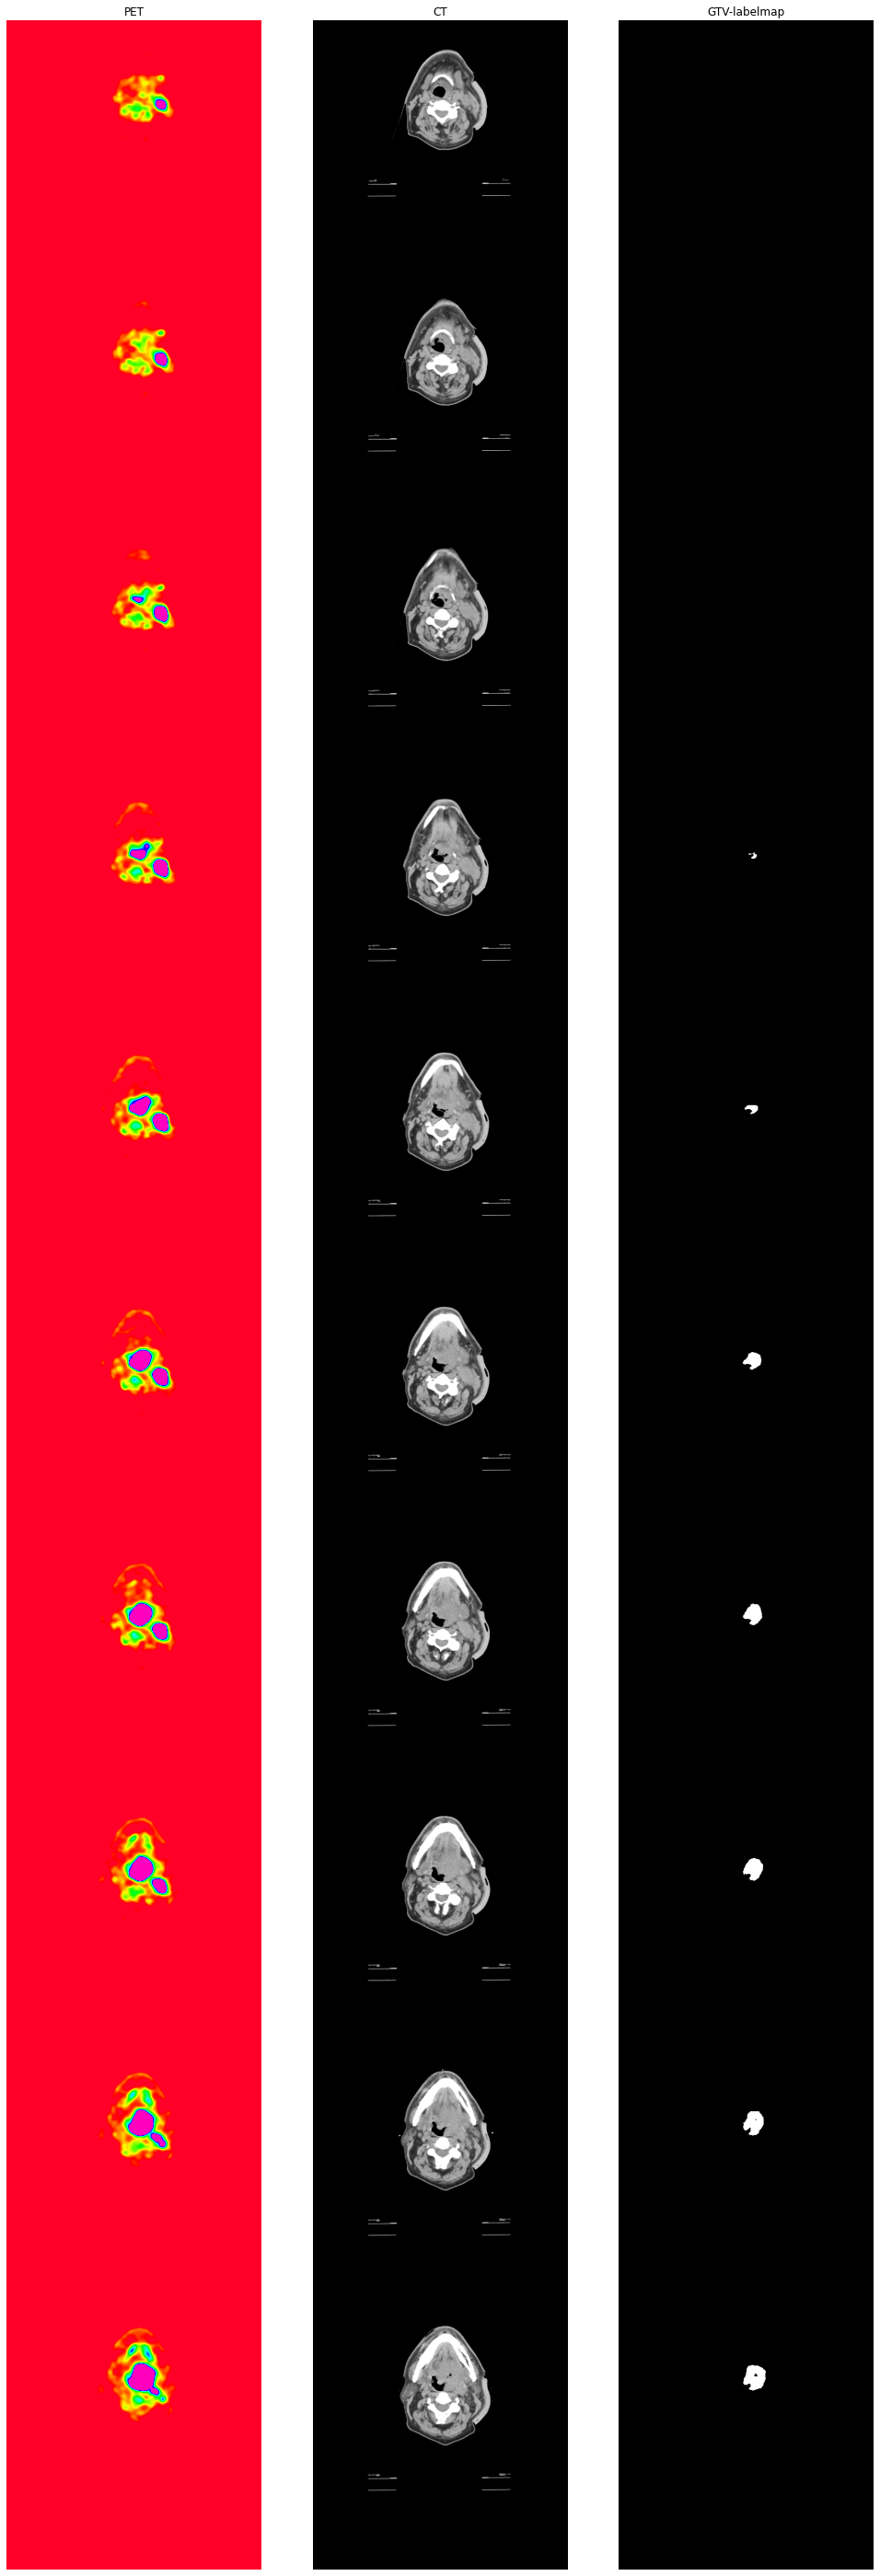

In [6]:
viz.multi_image_strips([PET_np, CT_np, GTV_labelmap_np],
                          modalities=['PET', 'CT', 'GTV-labelmap'],
                          idx_range=[45, 55],
                          view='axial',
                          subtitles=[])

### 1.2 Multichannel representation

In [7]:
PET_CT_dataset = HECKTORPETCTDataset(data_dir, 
                                     patient_id_filepath, 
                                     mode='training',
                                     preprocessor=preprocessor,
                                     input_representation='multichannel-volume', 
                                     augment_data=True)

sample_dict = PET_CT_dataset[sample_idx]
print(sample_dict['PET-CT'].shape)

# Extract into separate arrays for visualization
PET_np = sample_dict['PET-CT'].squeeze()[0,:,:,:].permute(2,1,0)
CT_np = sample_dict['PET-CT'].squeeze()[1,:,:,:].permute(2,1,0)
GTV_labelmap_np = sample_dict['GTV-labelmap'].squeeze().permute(2,1,0)

torch.Size([2, 100, 450, 450])


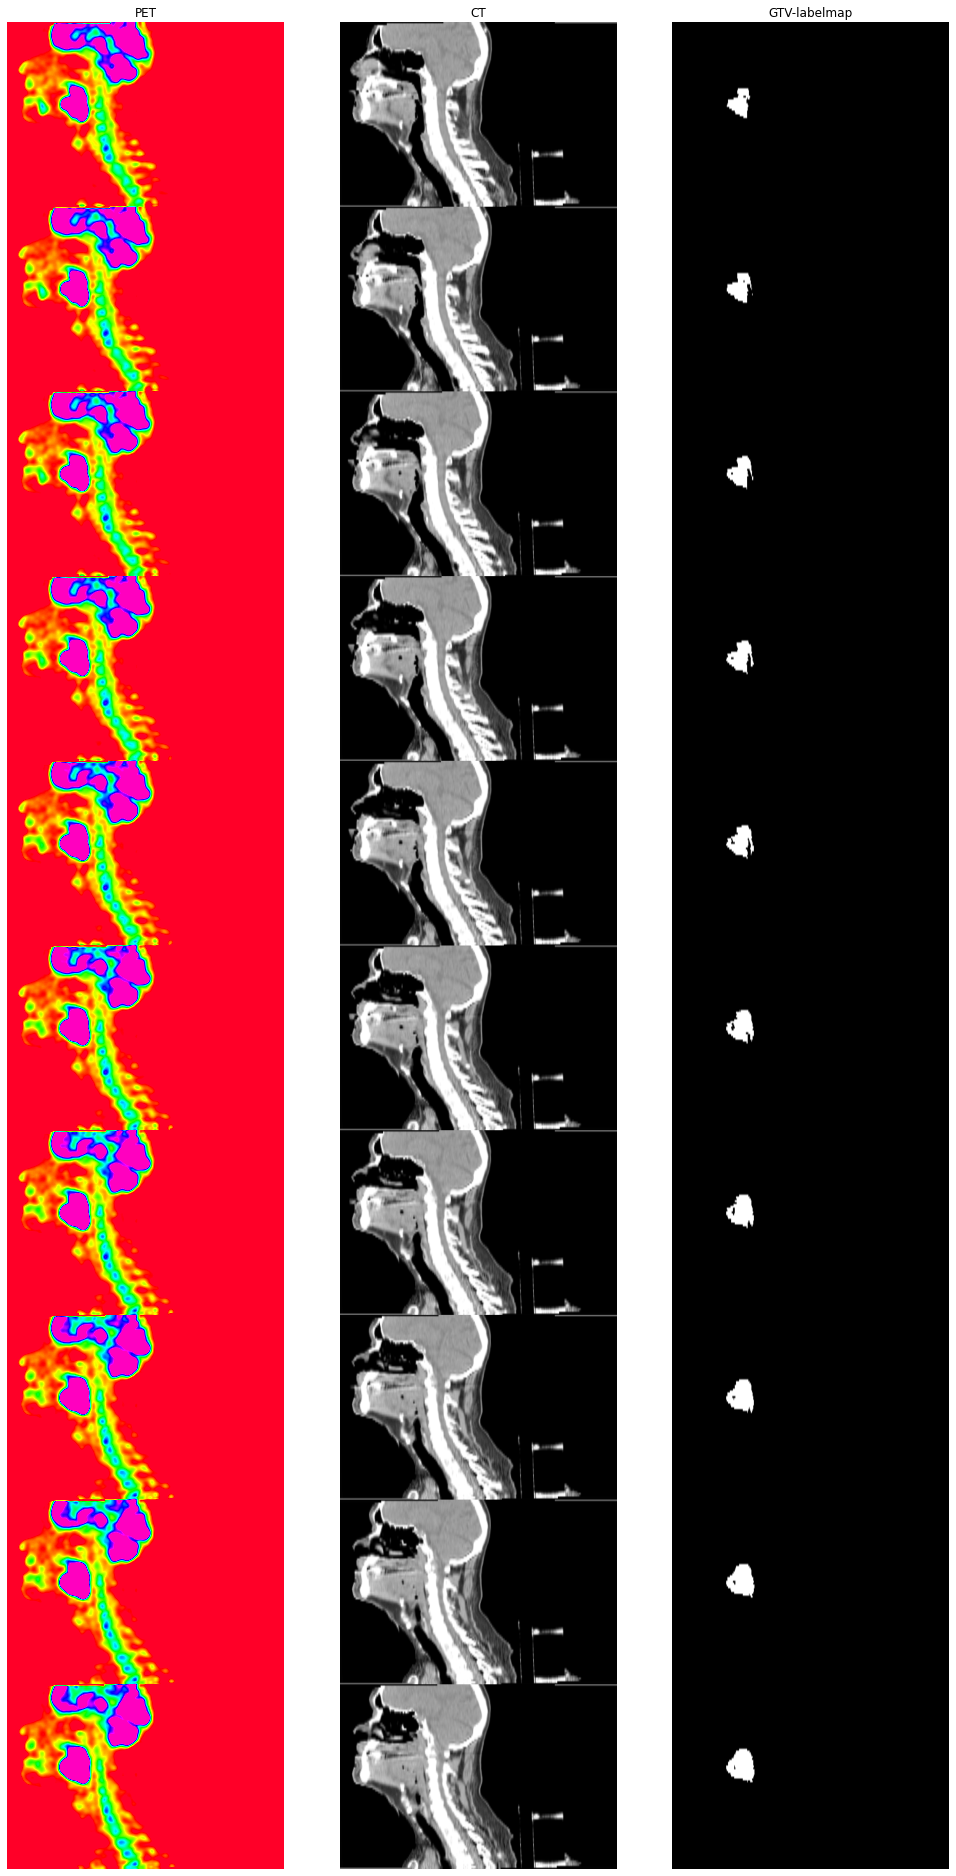

In [8]:
viz.multi_image_strips([PET_np, CT_np, GTV_labelmap_np],
                          modalities=['PET', 'CT', 'GTV-labelmap'],
                          idx_range=[230, 240],
                          view='sagittal',
                          subtitles=[])

### 1.3 Cross validation option

In [9]:
available_modes = [
                   'training', 'validation',
                   'cval-CHGJ-training', 'cval-CHGJ-validation',
                   'cval-CHMR-training', 'cval-CHMR-validation',
                   'cval-CHUM-training', 'cval-CHUM-validation',
                   'cval-CHUS-training', 'cval-CHUS-validation'
                  ]

for mode in available_modes:
    PET_CT_dataset = HECKTORPETCTDataset(data_dir, 
                                         patient_id_filepath, 
                                         mode=mode,
                                         preprocessor=preprocessor,
                                         input_representation='separate-volumes', 
                                         augment_data=False)
    print(mode)
    print("Patient data to be used:")
    print(PET_CT_dataset.patient_ids)
    print()

training
Patient data to be used:
['CHGJ007', 'CHGJ008', 'CHGJ010', 'CHGJ013', 'CHGJ015', 'CHGJ016', 'CHGJ017', 'CHGJ018', 'CHGJ025', 'CHGJ026', 'CHGJ028', 'CHGJ029', 'CHGJ030', 'CHGJ031', 'CHGJ032', 'CHGJ034', 'CHGJ035', 'CHGJ036', 'CHGJ037', 'CHGJ038', 'CHGJ039', 'CHGJ043', 'CHGJ046', 'CHGJ048', 'CHGJ050', 'CHGJ052', 'CHGJ053', 'CHGJ055', 'CHGJ057', 'CHGJ058', 'CHGJ062', 'CHGJ065', 'CHGJ066', 'CHGJ067', 'CHGJ069', 'CHGJ070', 'CHGJ071', 'CHGJ072', 'CHGJ073', 'CHGJ074', 'CHGJ076', 'CHGJ077', 'CHGJ078', 'CHGJ080', 'CHGJ081', 'CHGJ082', 'CHGJ083', 'CHGJ085', 'CHGJ086', 'CHGJ087', 'CHGJ088', 'CHGJ089', 'CHGJ090', 'CHGJ091', 'CHGJ092', 'CHMR001', 'CHMR004', 'CHMR005', 'CHMR011', 'CHMR012', 'CHMR013', 'CHMR014', 'CHMR016', 'CHMR020', 'CHMR021', 'CHMR023', 'CHMR024', 'CHMR025', 'CHMR028', 'CHMR029', 'CHMR030', 'CHMR034', 'CHMR040', 'CHUS003', 'CHUS004', 'CHUS005', 'CHUS006', 'CHUS007', 'CHUS008', 'CHUS009', 'CHUS010', 'CHUS013', 'CHUS015', 'CHUS016', 'CHUS019', 'CHUS020', 'CHUS021', 'CHUS022

## 2 Testing the patch queue

In [10]:
preprocessor = Preprocessor()
PET_CT_dataset = HECKTORPETCTDataset(data_dir, 
                                     patient_id_filepath, 
                                     mode='training',
                                     preprocessor=preprocessor,
                                     input_representation='separate-volumes', 
                                     augment_data=False)

In [11]:
# Define the patch sampler and the patch queue
patch_sampler = PatchSampler(patch_size=(240,240,80)) # Use even numbers
patch_queue = PatchQueue(PET_CT_dataset, 
                         max_length=16, 
                         samples_per_volume=8, 
                         sampler=patch_sampler, 
                         num_workers=0, 
                         shuffle_subjects=True, 
                         shuffle_patches=True)

# Get sample 
patch_sample = patch_queue[0]
print(patch_sample.keys())
print(patch_sample['PET'].shape)

dict_keys(['PET', 'CT', 'GTV-labelmap'])
torch.Size([1, 80, 240, 240])


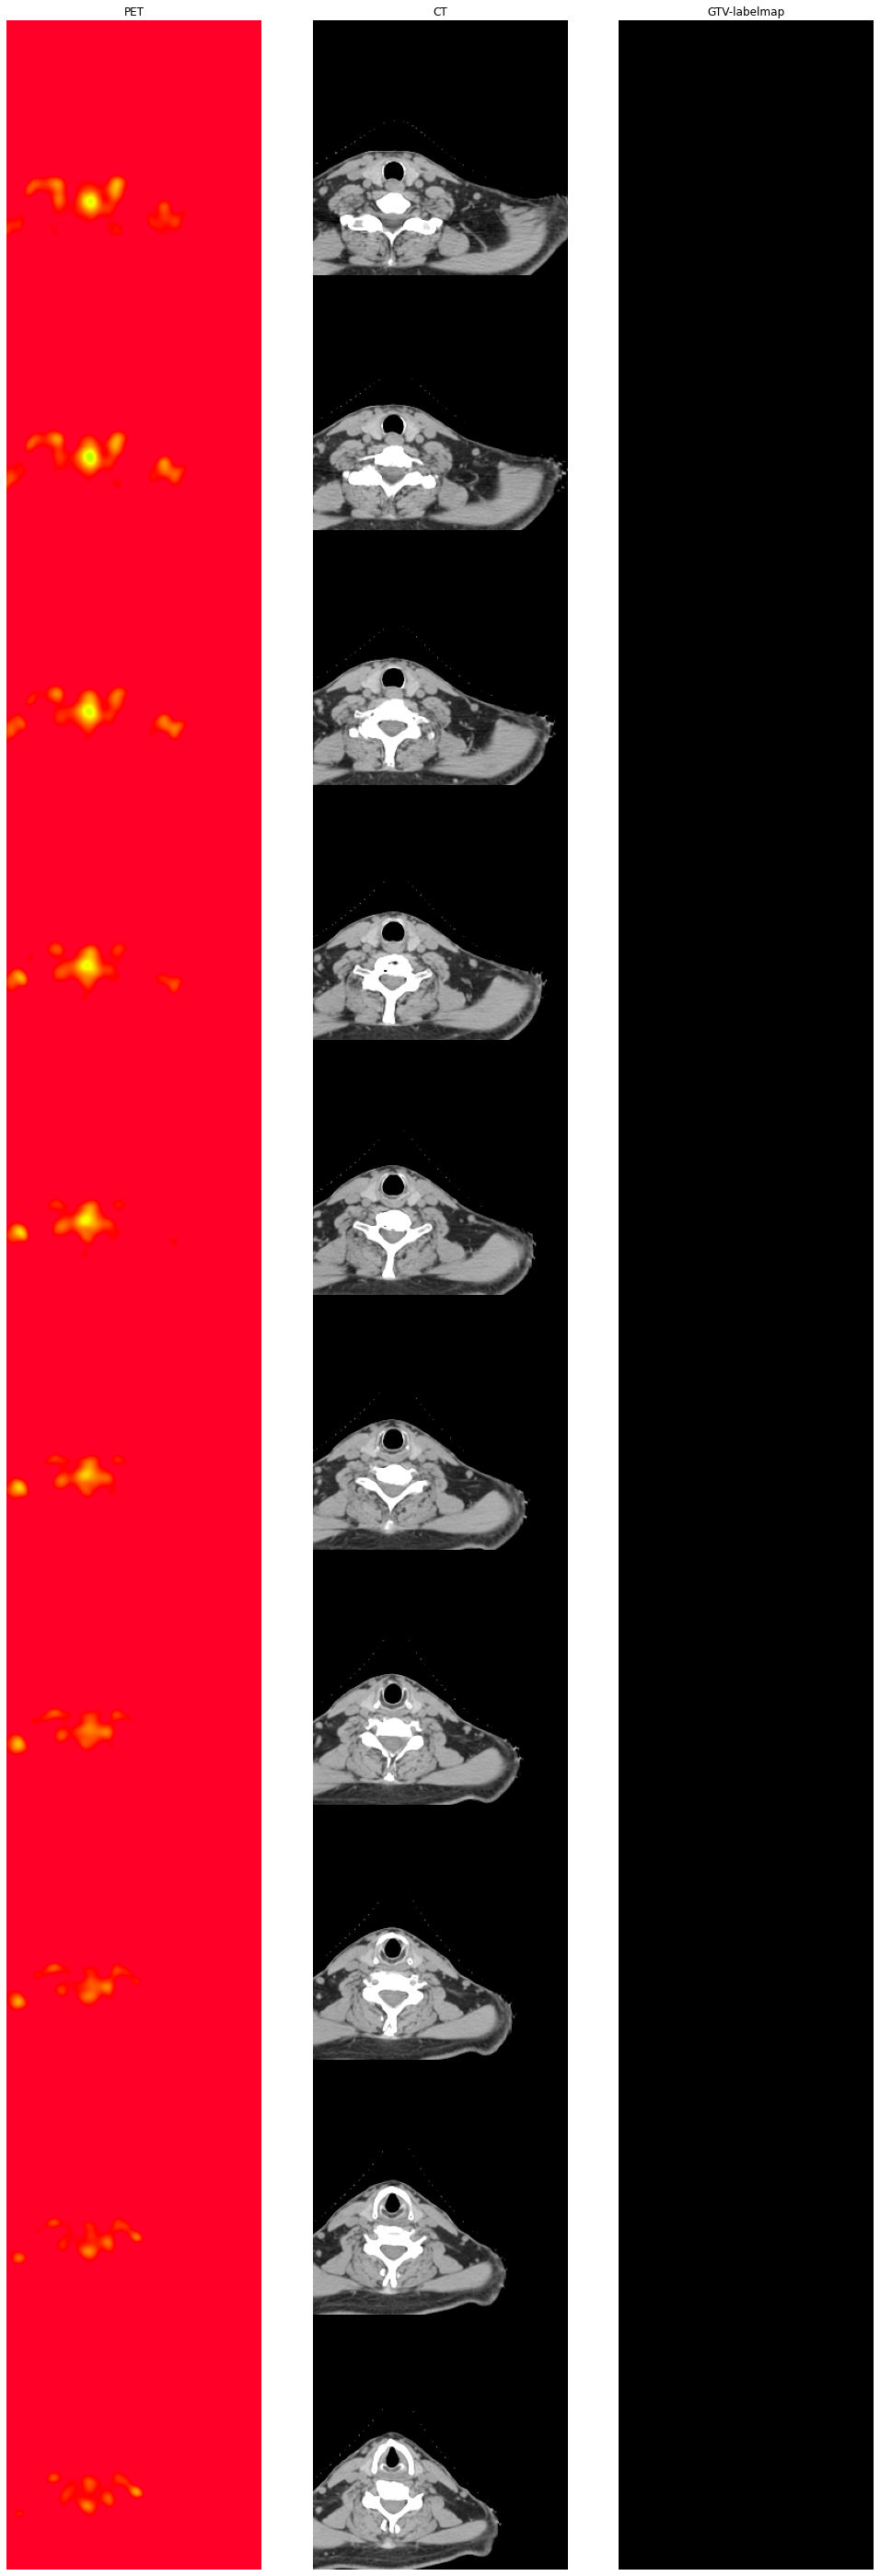

In [12]:
# Visualizing
PET_patch_np = patch_sample['PET'][0].permute(2,1,0).numpy()
CT_patch_np = patch_sample['CT'][0].permute(2,1,0).numpy()
GTV_labelmap_patch_np = patch_sample['GTV-labelmap'].permute(2,1,0).numpy()

viz.multi_image_strips([PET_patch_np, CT_patch_np, GTV_labelmap_patch_np],
                          modalities=['PET', 'CT', 'GTV-labelmap'],
                          idx_range=[0, 10],
                          view='axial',
                          subtitles=[])

## 3 Testing the patch loader

Batch: 1


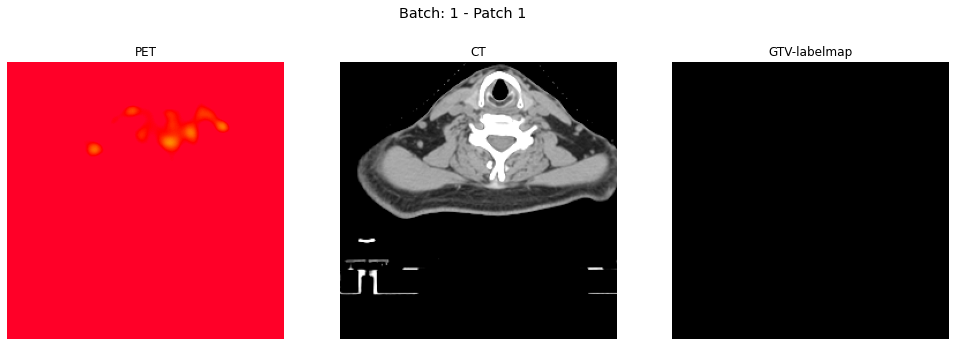

Batch: 2


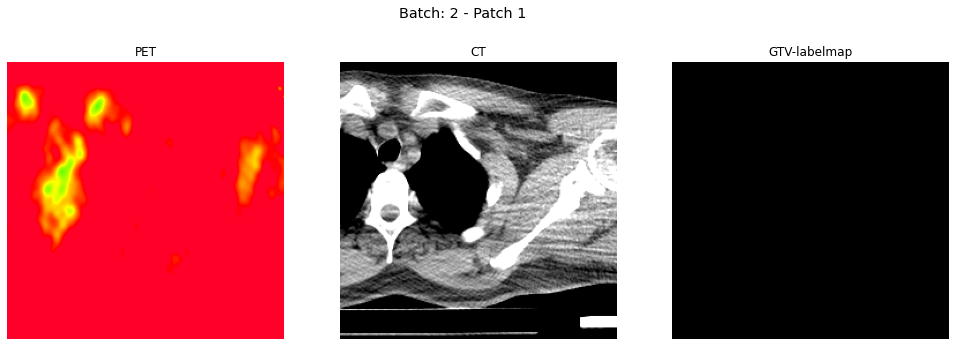

Batch: 3


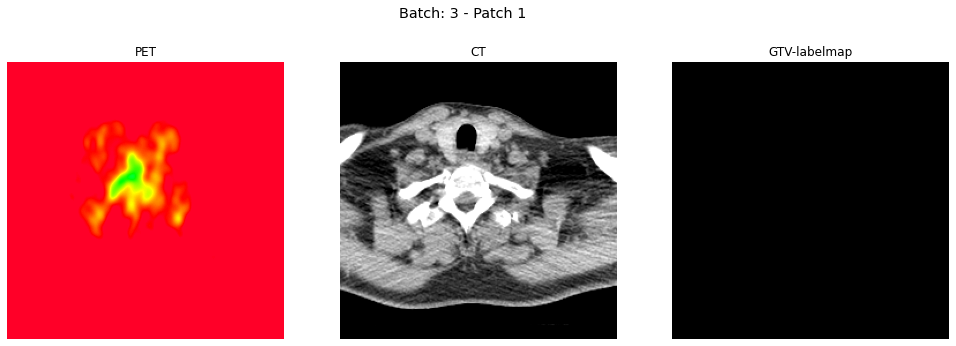

Batch: 4


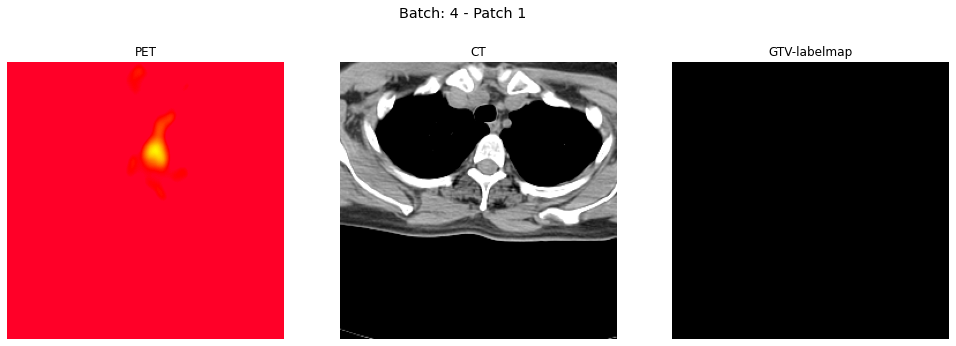

In [14]:
patch_loader = DataLoader(patch_queue, batch_size=4)

for i, batch_of_patches in enumerate(patch_loader):

    print(f"Batch: {i+1}")
    
    # Visualizing one slice of the 1st patch from this batch
    PET_patch_np = batch_of_patches['PET'][0][0].permute(2,1,0).numpy()
    CT_patch_np = batch_of_patches['CT'][0][0].permute(2,1,0).numpy()
    GTV_labelmap_patch_np = batch_of_patches['GTV-labelmap'][0].permute(2,1,0).numpy()

    viz.multi_image_strips([PET_patch_np, CT_patch_np, GTV_labelmap_patch_np],
                              modalities=['PET', 'CT', 'GTV-labelmap'],
                              idx_range=[0, 1],
                              view='axial',
                              subtitles=[],
                              title=f"Batch: {i+1} - Patch 1 - 1st axial slice")
    
    if i==3: break # Stop when the queue is empty. However, patch loader can be sampled infinitely.